# Walmart Sales Forecast

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
from catboost import CatBoostRegressor

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_store = pd.read_csv('data/stores.csv')
df_feature = pd.read_csv('data/features.csv')
df_submission_sample = pd.read_csv('data/sampleSubmission.csv')

In [4]:
# Merge df_train with df_store on the key Store

df_train_2 = pd.merge(df_train, df_store, on='Store') #inner join
df_train_2

df_test_2 = pd.merge(df_test, df_store, on='Store')
df_test_2

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315
2,1,1,2012-11-16,False,A,151315
3,1,1,2012-11-23,True,A,151315
4,1,1,2012-11-30,False,A,151315
...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221
115060,45,98,2013-07-05,False,B,118221
115061,45,98,2013-07-12,False,B,118221
115062,45,98,2013-07-19,False,B,118221


In [5]:
# Convert Date to type datetime

import pandas as pd

# Assuming 'Date' column exists in df_train and df_test
df_train_2['Date'] = pd.to_datetime(df_train_2['Date'])
df_test_2['Date'] = pd.to_datetime(df_test_2['Date'])

df_feature['Date'] = pd.to_datetime(df_feature['Date'])

In [6]:
# prompt: merge df_train with df_store on the key Store
df_feature.drop(columns=['IsHoliday'], axis=1, inplace=True)

df_train_2 = pd.merge(df_train_2, df_feature, on=['Store', 'Date'])
df_train_2

df_test_2 = pd.merge(df_test_2, df_feature, on=['Store', 'Date'])
df_test_2

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN
115060,45,98,2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN
115061,45,98,2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN


# EDA

In [7]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [8]:
for col in df_train_2.columns:
  if df_train_2[col].dtype in ['bool', 'object']:
    print(col, df_train_2[col].nunique()) #Number of unique values in each column

IsHoliday 2
Type 3


In [9]:
# Select categorical and numerical columns
categorical_columns = df_train_2.select_dtypes(include=['bool', 'object']).columns
numerical_columns = df_train_2.select_dtypes(exclude=['bool', 'object']).columns

# Define the target column
target_column = 'Weekly_Sales'

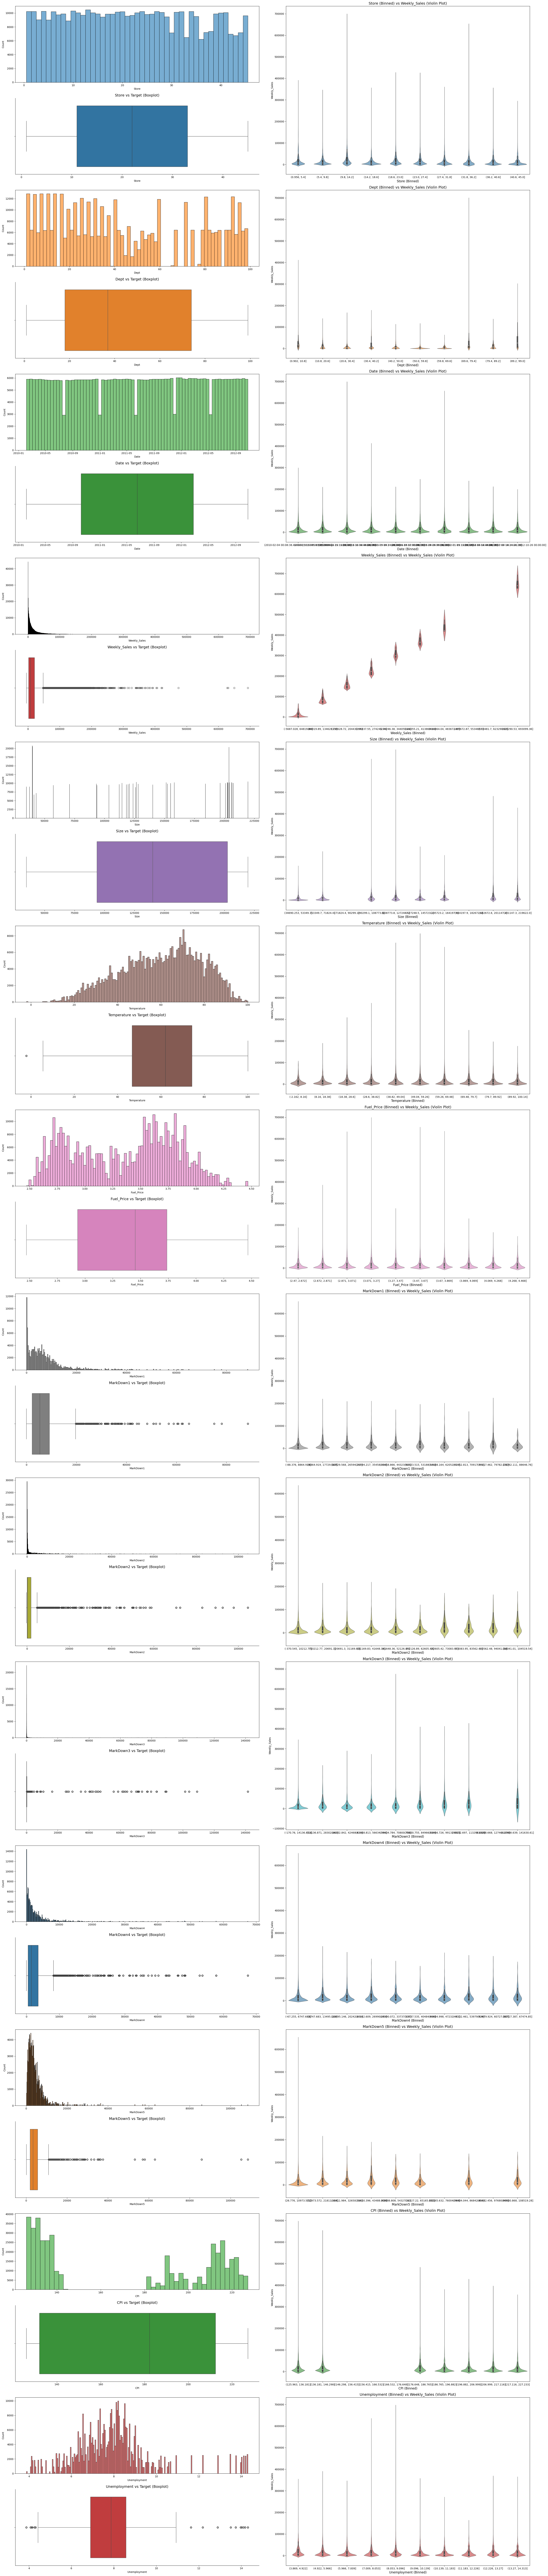

In [11]:
# Numerical columns

# Create a color palette for the columns
palette = sns.color_palette('tab10', len(numerical_columns))
color_dict = dict(zip(numerical_columns, palette))

# Create a grid of subplots for histograms, boxplots, and scatterplots/violin plots
fig = plt.figure(figsize=(30, 10 * len(numerical_columns)))
gs = gridspec.GridSpec(2 * len(numerical_columns), 2, figure=fig)

df_binned = df_train_2.copy()

for i, column in enumerate(numerical_columns):

    if df_train_2[column].nunique() > 50: discrete = False
    else : discrete = True

    # Plot histogram with a unique color
    ax_hist = fig.add_subplot(gs[2 * i, 0])
    sns.histplot(
        data=df_train_2, x=column, fill=True, common_norm=False, alpha=0.6,
        linewidth=0.8, color=color_dict[column], ax=ax_hist,  discrete = discrete
    )

    # Plot boxplot with the same unique color
    ax_box = fig.add_subplot(gs[2 * i + 1, 0])
    sns.boxplot(data=df_train_2, x=column, ax=ax_box, color=color_dict[column])
    ax_box.set_title(f'{column} vs Target (Boxplot)', fontsize=14)
    sns.despine(ax=ax_box)

    # Conditional plot: violin plot or barplot based on unique values, fallback to scatterplot
    ax_conditional = fig.add_subplot(gs[2 * i:2 * i + 2, 1])  # Merges 2 rows
    if df_train_2[column].nunique() <= 10:
        # If the column has 10 or fewer unique values, use a violin plot
        sns.violinplot(data=df_train_2, x=column, y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} vs {target_column} (Violin Plot)', fontsize=14)
    else:
        # Bin the column into 10 intervals, but keep original target column values
        df_binned['Binned Column'] = pd.cut(df_train_2[column], bins=10)
        sns.violinplot(data=df_binned, x='Binned Column', y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} (Binned) vs {target_column} (Violin Plot)', fontsize=14)
        ax_conditional.set_xlabel(f'{column} (Binned)', fontsize=12)

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

array([[<Axes: xlabel='Store', ylabel='Store'>,
        <Axes: xlabel='Dept', ylabel='Store'>,
        <Axes: xlabel='Weekly_Sales', ylabel='Store'>,
        <Axes: xlabel='IsHoliday', ylabel='Store'>,
        <Axes: xlabel='Size', ylabel='Store'>,
        <Axes: xlabel='Temperature', ylabel='Store'>,
        <Axes: xlabel='Fuel_Price', ylabel='Store'>,
        <Axes: xlabel='MarkDown1', ylabel='Store'>,
        <Axes: xlabel='MarkDown2', ylabel='Store'>,
        <Axes: xlabel='MarkDown3', ylabel='Store'>,
        <Axes: xlabel='MarkDown4', ylabel='Store'>,
        <Axes: xlabel='MarkDown5', ylabel='Store'>,
        <Axes: xlabel='CPI', ylabel='Store'>,
        <Axes: xlabel='Unemployment', ylabel='Store'>],
       [<Axes: xlabel='Store', ylabel='Dept'>,
        <Axes: xlabel='Dept', ylabel='Dept'>,
        <Axes: xlabel='Weekly_Sales', ylabel='Dept'>,
        <Axes: xlabel='IsHoliday', ylabel='Dept'>,
        <Axes: xlabel='Size', ylabel='Dept'>,
        <Axes: xlabel='Temperature', y

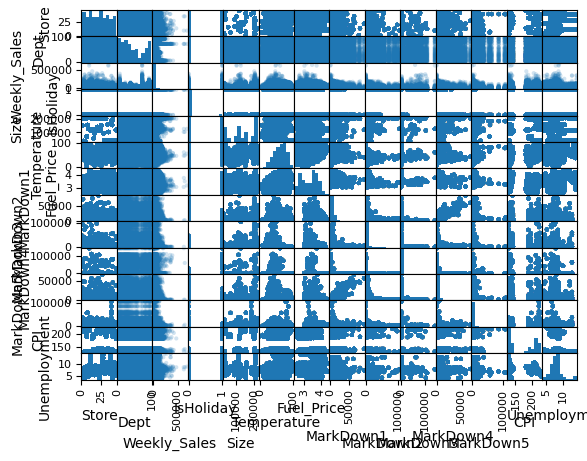

In [13]:
df_train_2['IsHoliday'] = df_train_2['IsHoliday'].astype(int)
pd.plotting.scatter_matrix(df_train_2, alpha=0.2)

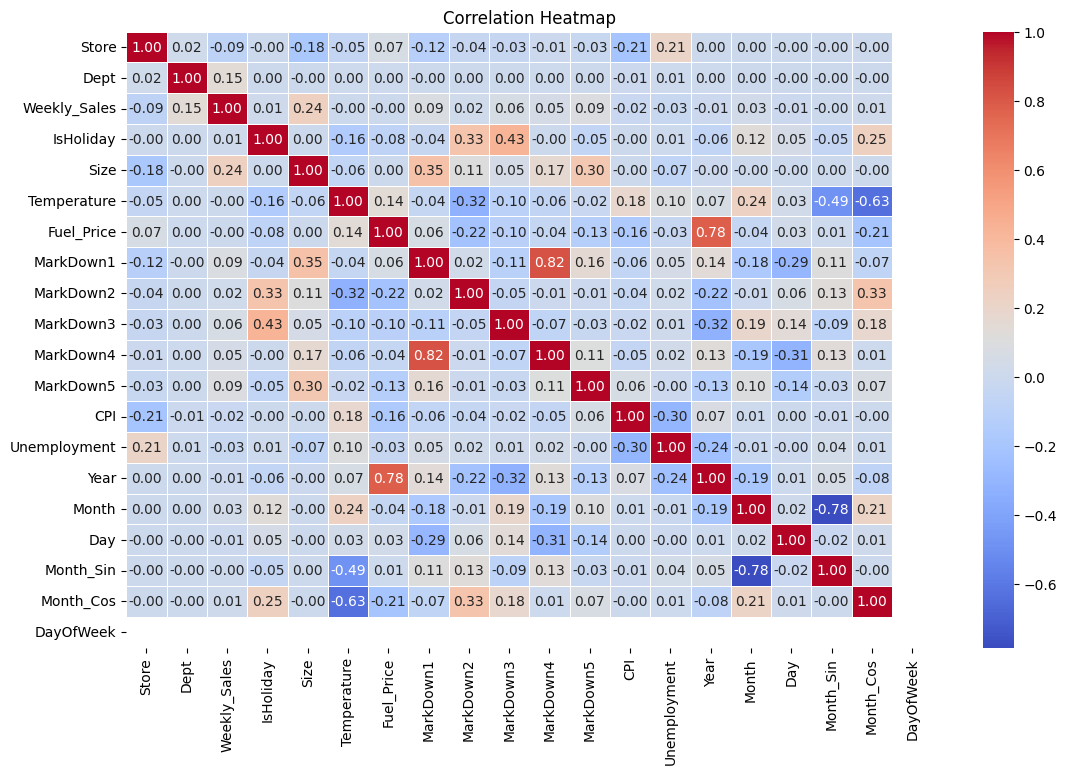

In [27]:
def plot_correlation_heatmap(df, figsize=(13, 8), cmap="coolwarm", annot=True, fmt=".2f"):
    """
    Plots a correlation heatmap for a given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    figsize (tuple): Figure size (width, height).
    cmap (str): Colormap for heatmap.
    annot (bool): Whether to annotate the heatmap with correlation values.
    fmt (str): Format for annotation text.
    """
    plt.figure(figsize=figsize)
    numeric_df = df.select_dtypes(include=["number"])
    corr_matrix = numeric_df.corr()
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, fmt=fmt, linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

# Example usage:
# df = pd.read_csv("your_dataset.csv")  # Load your dataset
plot_correlation_heatmap(df_train_2)


# Model

In [14]:
for col in df_train_2.columns:
  if df_train_2[col].dtype in ['object']:
    # print(col, df_train_2[col].nunique()) #Number of unique values in each column
    df_train_2[col] = df_train_2[col].astype('str')
  elif df_train_2[col].dtype in ['bool']:
    df_train_2[col] = df_train_2[col].astype('int')

In [15]:
for col in df_test_2.columns:
  if df_test_2[col].dtype in ['object']:
    # print(col, df_train_2[col].nunique()) #Number of unique values in each column
    df_test_2[col] = df_test_2[col].astype('str')
  elif df_test_2[col].dtype in ['bool']:
    df_test_2[col] = df_test_2[col].astype('int')

In [16]:
def feature_engineer(df):
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Day'] = df['Date'].dt.day

  # Cyclical encode Month only (Since data is recorded weekly / every 7 days)
  df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
  df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

  df['DayOfWeek'] = df['Date'].dt.dayofweek

  # Lag and Moving average features
  # df["Weekly_Sales_Lag_1"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
  # df["Weekly_Sales_Lag_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)
  # df["Weekly_Sales_MA_4"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].rolling(window=4).mean().reset_index(level=0, drop=True)


  df.drop(columns=['Date'], axis=1, inplace=True)

  return df

df_train_2 = feature_engineer(df_train_2)
df_test_2 = feature_engineer(df_test_2)

In [17]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  int64  
 4   Type          421570 non-null  object 
 5   Size          421570 non-null  int64  
 6   Temperature   421570 non-null  float64
 7   Fuel_Price    421570 non-null  float64
 8   MarkDown1     150681 non-null  float64
 9   MarkDown2     111248 non-null  float64
 10  MarkDown3     137091 non-null  float64
 11  MarkDown4     134967 non-null  float64
 12  MarkDown5     151432 non-null  float64
 13  CPI           421570 non-null  float64
 14  Unemployment  421570 non-null  float64
 15  Year          421570 non-null  int32  
 16  Month         421570 non-null  int32  
 17  Day           421570 non-null  int32  
 18  Mont

In [18]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   IsHoliday     115064 non-null  int64  
 3   Type          115064 non-null  object 
 4   Size          115064 non-null  int64  
 5   Temperature   115064 non-null  float64
 6   Fuel_Price    115064 non-null  float64
 7   MarkDown1     114915 non-null  float64
 8   MarkDown2     86437 non-null   float64
 9   MarkDown3     105235 non-null  float64
 10  MarkDown4     102176 non-null  float64
 11  MarkDown5     115064 non-null  float64
 12  CPI           76902 non-null   float64
 13  Unemployment  76902 non-null   float64
 14  Year          115064 non-null  int32  
 15  Month         115064 non-null  int32  
 16  Day           115064 non-null  int32  
 17  Month_Sin     115064 non-null  float64
 18  Mont

In [21]:
df_train_2

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Month_Sin,Month_Cos,DayOfWeek
0,1,1,24924.50,0,A,151315,42.31,2.572,NaN,NaN,...,NaN,NaN,211.096358,8.106,2010,2,5,0.866025,5.000000e-01,4
1,1,1,46039.49,1,A,151315,38.51,2.548,NaN,NaN,...,NaN,NaN,211.242170,8.106,2010,2,12,0.866025,5.000000e-01,4
2,1,1,41595.55,0,A,151315,39.93,2.514,NaN,NaN,...,NaN,NaN,211.289143,8.106,2010,2,19,0.866025,5.000000e-01,4
3,1,1,19403.54,0,A,151315,46.63,2.561,NaN,NaN,...,NaN,NaN,211.319643,8.106,2010,2,26,0.866025,5.000000e-01,4
4,1,1,21827.90,0,A,151315,46.50,2.625,NaN,NaN,...,NaN,NaN,211.350143,8.106,2010,3,5,1.000000,6.123234e-17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,0,B,118221,64.88,3.997,4556.61,20.64,...,1601.01,3288.25,192.013558,8.684,2012,9,28,-1.000000,-1.836970e-16,4
421566,45,98,628.10,0,B,118221,64.89,3.985,5046.74,NaN,...,2253.43,2340.01,192.170412,8.667,2012,10,5,-0.866025,5.000000e-01,4
421567,45,98,1061.02,0,B,118221,54.47,4.000,1956.28,NaN,...,599.32,3990.54,192.327265,8.667,2012,10,12,-0.866025,5.000000e-01,4
421568,45,98,760.01,0,B,118221,56.47,3.969,2004.02,NaN,...,437.73,1537.49,192.330854,8.667,2012,10,19,-0.866025,5.000000e-01,4


In [22]:
df_test_2

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Month_Sin,Month_Cos,DayOfWeek
0,1,1,0,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,-5.000000e-01,0.866025,4
1,1,1,0,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,-5.000000e-01,0.866025,4
2,1,1,0,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,-5.000000e-01,0.866025,4
3,1,1,1,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,-5.000000e-01,0.866025,4
4,1,1,0,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,-5.000000e-01,0.866025,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,0,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,2013,6,28,1.224647e-16,-1.000000,4
115060,45,98,0,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,2013,7,5,-5.000000e-01,-0.866025,4
115061,45,98,0,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,2013,7,12,-5.000000e-01,-0.866025,4
115062,45,98,0,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,2013,7,19,-5.000000e-01,-0.866025,4


In [23]:
# Build a catboost regressor to predict Weekly_Sales

from catboost import CatBoostRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming df_train_2 contains your features (X) and 'Weekly_Sales' is your target (y)
X = df_train_2.drop('Weekly_Sales', axis=1)
y = df_train_2['Weekly_Sales']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get categorical feature indices
# categorical_features_indices = np.where(X.dtypes != np.float64)[0]
categorical_features_indices = np.where(X.dtypes == 'object')[0]

# Initialize CatBoostRegressor, specifying categorical features
model = CatBoostRegressor(iterations=1000,  # Adjust as needed
                          learning_rate=0.1,  # Adjust as needed
                          depth=6,            # Adjust as needed
                          loss_function='MAE', # Or other suitable loss
                          verbose=10,          # Print progress every 10 iterations
                          cat_features=categorical_features_indices) # Define categorical features


# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)


# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)

print(f"\nMAE: {mae}")
print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")

0:	learn: 12953.6424511	total: 137ms	remaining: 2m 16s
10:	learn: 10501.5262188	total: 1.03s	remaining: 1m 32s
20:	learn: 9131.4397121	total: 1.84s	remaining: 1m 25s
30:	learn: 8626.6158346	total: 2.61s	remaining: 1m 21s
40:	learn: 8226.0812885	total: 3.46s	remaining: 1m 21s
50:	learn: 7855.0518202	total: 4.21s	remaining: 1m 18s
60:	learn: 7598.8783084	total: 4.86s	remaining: 1m 14s
70:	learn: 7256.7301334	total: 5.53s	remaining: 1m 12s
80:	learn: 6844.2488205	total: 6.37s	remaining: 1m 12s
90:	learn: 6568.9519274	total: 7.14s	remaining: 1m 11s
100:	learn: 6367.3436288	total: 7.83s	remaining: 1m 9s
110:	learn: 6198.2325539	total: 8.51s	remaining: 1m 8s
120:	learn: 5989.0594493	total: 9.21s	remaining: 1m 6s
130:	learn: 5865.5137596	total: 10.1s	remaining: 1m 7s
140:	learn: 5743.9250133	total: 10.9s	remaining: 1m 6s
150:	learn: 5652.1977929	total: 11.7s	remaining: 1m 5s
160:	learn: 5523.2166583	total: 12.5s	remaining: 1m 4s
170:	learn: 5456.3966291	total: 13.3s	remaining: 1m 4s
180:	lear

In [28]:
y_pred

array([51438.26469207,  3178.72635676, 10650.78435937, ...,
       10934.98080646, 13017.18749301, 23553.61669185])

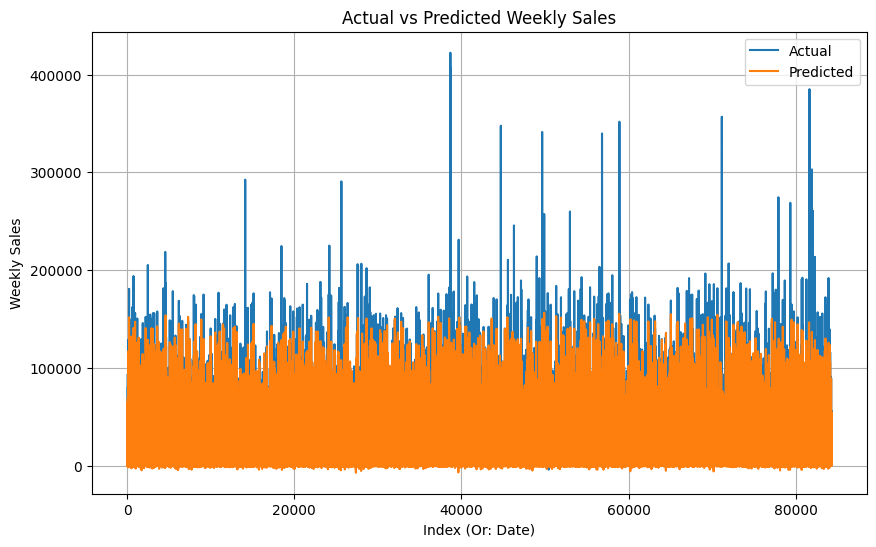

In [33]:
# Plot index against Weekly_Sales for both actual and predicted values

# Assuming 'forecast' DataFrame from Prophet model and 'y_test' from SARIMAX model are available

index_temp = [i for i in range(len(y_val))]
# index_temp

plt.figure(figsize=(10, 6))

# Plot actual values (from the original dataframe)
plt.plot(index_temp, y_val, label='Actual')
plt.plot(index_temp, y_pred, label='Predicted')

# # Plot predicted values (Prophet)
# plt.plot(df_prophet_test['ds'].head(100), forecast['yhat'].head(100), label='Prophet Predicted')


# # Plot predicted values (SARIMAX) - Assuming 'forecast' has the same index as 'y_test'
# plt.plot(df_subset_train.index[-len(forecast):], forecast, label='SARIMAX Predicted')


plt.xlabel('Index (Or: Date)')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

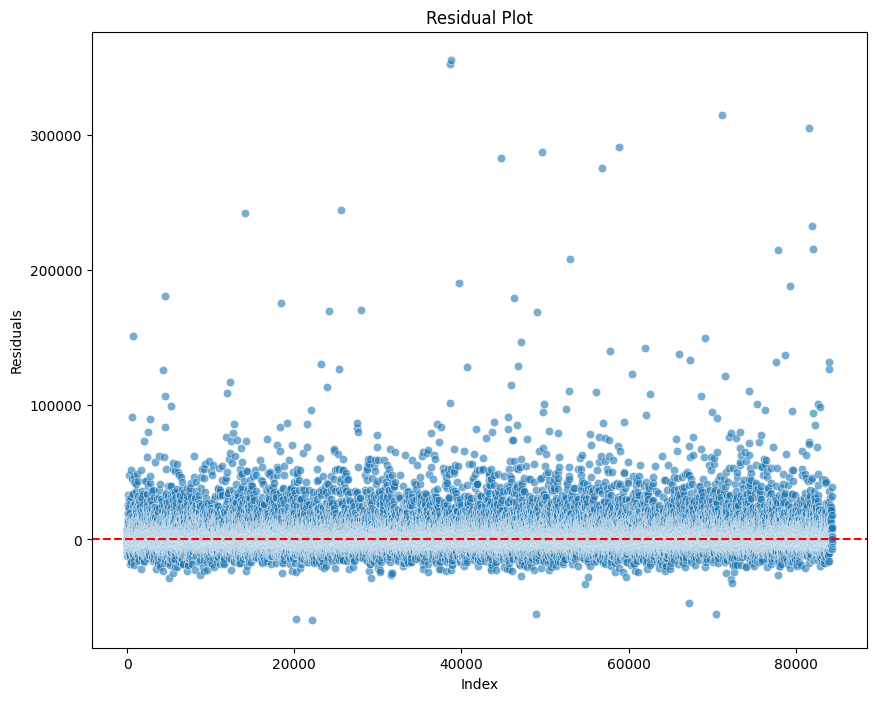

In [32]:
def residual_plot(y_actual, y_pred, figsize=(10, 8)):
    """
    Plots a residual plot (y_actual - y_pred) to assess model performance.

    Parameters:
    y_actual (array-like): Actual target values.
    y_pred (array-like): Predicted values from the model.
    figsize (tuple): Figure size (width, height).
    """
    index_temp = [i for i in range(len(y_actual))]
    residuals = y_actual - y_pred  # Compute residuals: Actual value relative to predicted value
    
    plt.figure(figsize=figsize)
    sns.scatterplot(x=index_temp, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')  # Reference line at 0
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()

# Example usage:
residual_plot(y_val, y_pred)

# Plot shows that on average, Y-actual > y_pred (Our prediction model is underestimating the actual value)